In [1]:
from scipy.stats import multivariate_normal
import numpy as np
from scipy.signal import fftconvolve
from skimage import restoration

std = 3.0
f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y]))
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
kernel1 = f(X, Y)
kernel1 = kernel1 / kernel1.sum()
gauss_filt = kernel1

np.random.seed(0)
kernel2 = np.random.rand(*kernel1.shape)
kernel2 = kernel2 / kernel2.sum()
random_filt = kernel2

kernel3 = np.ones_like(kernel1)
kernel3 = kernel3 / kernel3.sum()
smooth_filt = kernel3

filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel1, mode='same')))
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel2, mode='same')))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))

In [10]:
import torch

class MnistNet(torch.nn.Module):
    def __init__(self, c=1, m=[20, 20, 5]):
        super(MnistNet, self).__init__()
        self.m = m
        self.conv1 = torch.nn.Conv2d(c, self.m[0], 5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(self.m[0], self.m[1], 5, stride=1, padding=0)
        self.fc = torch.nn.Linear(4*4*self.m[1], m[2])
        self.scale = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*self.m[1])
        x = self.fc(x)
        return x, self.scale*x
    
device = 'cuda:0'
Qnet = MnistNet(c=1, m=[20, 20, 5]).to(device)
Qnet.load_state_dict(torch.load('onlyGauss/channel01_weight000_seed00/Qnet020000.pth'))

<All keys matched successfully>

In [5]:
from matplotlib import pyplot as plt
from torchvision import datasets
import numpy as np
from train_agent import blur, next_state
import os

# net (1, 20, 5)
data = datasets.MNIST(root='./data', train=False, download=True)
np.random.seed(100)

def test_restoration(kernel, C, kname):
    os.makedirs('restoration', exist_ok=True)
    img = data.data[np.random.randint(0, data.data.shape[0])].numpy() / 255
    blurred_img = blur(img, kernel, c=C)

    now = torch.from_numpy(blurred_img).to(torch.float) # (1, 28, 28)
    labels = ['None', 'gauss', 'random', 'wiener_gauss', 'wiener_random']
    mse = torch.mean((now-torch.from_numpy(img))**2).item()

    # 初期画像
    fig = plt.figure(figsize=(16, 12))
    plt.subplot(1, 6, 1)
    plt.title('blurred by %s x %d\n%lf' % (kname, C, mse))
    plt.axis('off')
    plt.imshow(blurred_img)

    for i in range(2, 2 + 5):
        with torch.no_grad():
            q, _ = Qnet(now.unsqueeze(0).unsqueeze(0).to(device))
            q = q[0].cpu().numpy()
        a = np.argmax(q)
        with torch.no_grad():
            now = torch.from_numpy(filt[a](now.numpy())).to(torch.float)
        mse = torch.mean((now-torch.from_numpy(img))**2).item()
        plt.subplot(1, 6, i)
        plt.title('%s\n%lf' % (labels[a], mse))
        plt.axis('off')
        plt.imshow(now)
    fig.savefig('restoration/%sx%d.png' % (kname, C))

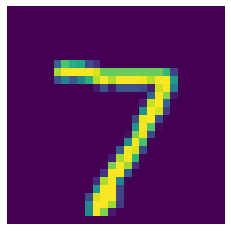

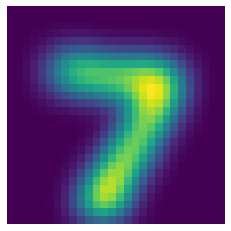

In [8]:
from matplotlib import pyplot as plt
from scipy.signal import fftconvolve

img = data.data[0].numpy() / 255
plt.imshow(img)
plt.axis('off')
plt.show()

decay = img
for _ in range(3):
    decay = fftconvolve(decay, kernel1, mode='same')
plt.imshow(decay)
plt.axis('off')
plt.show()

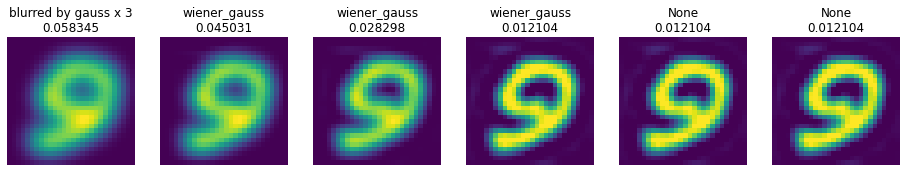

In [17]:
# gauus x 3
test_restoration(gauss_filt, 3, 'gauss')

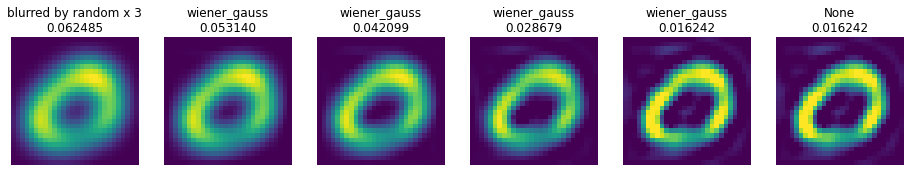

In [27]:
test_restoration(random_filt, 3, 'random')

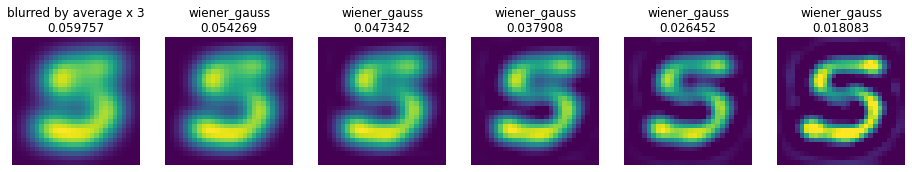

In [26]:
# smooth x 3
test_restoration(smooth_filt, 3, 'average')

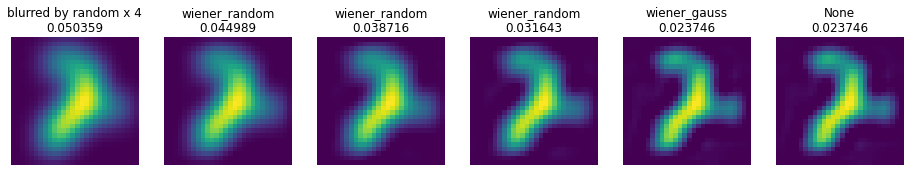

In [34]:
test_restoration(random_filt, 4, 'random')

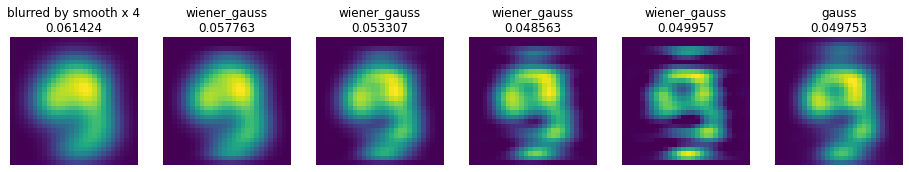

In [14]:
test_restoration(smooth_filt, 4, 'smooth')

In [16]:
from itertools import product
from tqdm.notebook import tqdm
from collections import defaultdict

def test_random_minMSE(kernel, C, N=10000):
    # 3 x 3
    mse_mins = []
    hist = defaultdict(int)
    for i in tqdm(range(N)):
        img = data.data[i].numpy() / 255
        blurred_img = blur(img, kernel, c=C)
        init = blurred_img # (28, 28)
        mse_min = 100
        k = (0,)
        for j in range(5):
            for fil_index in product([3, 4], repeat=j):
                now = init
                for a in fil_index:
                    now = filt[a](now)
                mse = np.mean((now-img)**2)
                if mse < mse_min:
                    mse_min = mse
                    k = fil_index
        hist[k] += 1
        mse_mins.append(mse_min)
    return hist, np.array(mse_mins).mean()

In [14]:
test_random_minMSE(kernel1, 4)

0.016840561933010405

In [17]:
result = test_random_minMSE(kernel2, 4)

defaultdict(<class 'int'>, {(3, 3, 3, 4): 2713, (3, 3, 4): 1141, (3, 3, 4, 4): 1267, (3, 3, 3, 3): 2218, (3, 3, 3): 895, (4, 4, 4): 411, (3, 4): 20, (4, 4, 4, 3): 125, (3, 4, 4, 4): 433, (3, 4, 4): 221, (4, 4, 3, 4): 30, (4, 4, 3): 107, (4, 4, 4, 4): 260, (3, 3, 4, 3): 48, (4, 3): 11, (4, 3, 3): 3, (4, 4): 53, (4, 3, 3, 4): 3, (3, 3): 6, (4, 3, 4, 4): 15, (4, 3, 4): 3, (3, 4, 3): 6, (3, 4, 3, 4): 4, (4, 4, 3, 3): 6, (3, 4, 4, 3): 1})


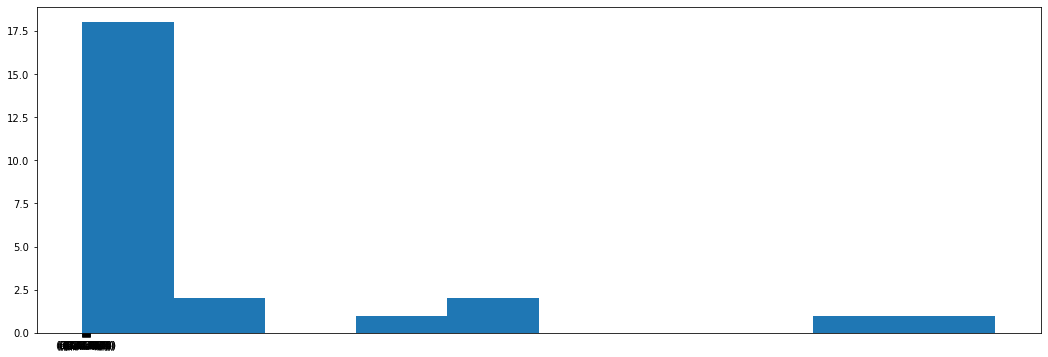

In [23]:
plt.figure(figsize=(18, 6)) 
plt.hist(result[0].values())
plt.xticks(range(len(result[0])), result[0].keys())
plt.show()

In [27]:
new_dict = {}
for key, item in result[0].items():
    new_dict[key] = item * 100/ 10000
print(new_dict)

{(3, 3, 3, 4): 27.13, (3, 3, 4): 11.41, (3, 3, 4, 4): 12.67, (3, 3, 3, 3): 22.18, (3, 3, 3): 8.95, (4, 4, 4): 4.11, (3, 4): 0.2, (4, 4, 4, 3): 1.25, (3, 4, 4, 4): 4.33, (3, 4, 4): 2.21, (4, 4, 3, 4): 0.3, (4, 4, 3): 1.07, (4, 4, 4, 4): 2.6, (3, 3, 4, 3): 0.48, (4, 3): 0.11, (4, 3, 3): 0.03, (4, 4): 0.53, (4, 3, 3, 4): 0.03, (3, 3): 0.06, (4, 3, 4, 4): 0.15, (4, 3, 4): 0.03, (3, 4, 3): 0.06, (3, 4, 3, 4): 0.04, (4, 4, 3, 3): 0.06, (3, 4, 4, 3): 0.01}


In [28]:
result[1]

0.03275800177886061

In [7]:
list(product([3, 4], repeat=5))

[(3, 3, 3, 3, 3),
 (3, 3, 3, 3, 4),
 (3, 3, 3, 4, 3),
 (3, 3, 3, 4, 4),
 (3, 3, 4, 3, 3),
 (3, 3, 4, 3, 4),
 (3, 3, 4, 4, 3),
 (3, 3, 4, 4, 4),
 (3, 4, 3, 3, 3),
 (3, 4, 3, 3, 4),
 (3, 4, 3, 4, 3),
 (3, 4, 3, 4, 4),
 (3, 4, 4, 3, 3),
 (3, 4, 4, 3, 4),
 (3, 4, 4, 4, 3),
 (3, 4, 4, 4, 4),
 (4, 3, 3, 3, 3),
 (4, 3, 3, 3, 4),
 (4, 3, 3, 4, 3),
 (4, 3, 3, 4, 4),
 (4, 3, 4, 3, 3),
 (4, 3, 4, 3, 4),
 (4, 3, 4, 4, 3),
 (4, 3, 4, 4, 4),
 (4, 4, 3, 3, 3),
 (4, 4, 3, 3, 4),
 (4, 4, 3, 4, 3),
 (4, 4, 3, 4, 4),
 (4, 4, 4, 3, 3),
 (4, 4, 4, 3, 4),
 (4, 4, 4, 4, 3),
 (4, 4, 4, 4, 4)]

In [29]:
from itertools import product
from tqdm.notebook import tqdm

def test_minMSE(kernel, C, N=10000):
    # 3 x 3
    mse_mins = []
    for j in tqdm(range(N)):
        img = data.data[j].numpy() / 255
        blurred_img = blur(img, kernel, c=C)
        init = blurred_img # (28, 28)
        mse_min = 100
        for i in range(5, 0, -1):
            for idx in product([3, 4], repeat=5-i):
                now = init
                for a in idx:
                    now = filt[a](now)
                mse = np.mean((now-img)**2)
                if mse < mse_min:
                    mse_min = mse
        mse_mins.append(mse_min)
    return np.array(mse_mins).mean()

In [31]:
test_minMSE(kernel2, 4)

KeyboardInterrupt: 

In [46]:
!wget https://farm1.static.flickr.com/200/525118682_8b70d91928.jpg

--2021-02-03 18:53:12--  https://farm1.static.flickr.com/200/525118682_8b70d91928.jpg
Resolving farm1.static.flickr.com (farm1.static.flickr.com)... 13.249.157.34, 2600:9000:2112:bc00:0:5a51:64c9:c681, 2600:9000:2112:b200:0:5a51:64c9:c681, ...
Connecting to farm1.static.flickr.com (farm1.static.flickr.com)|13.249.157.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘525118682_8b70d91928.jpg’

525118682_8b70d9192     [ <=>                ]  87.80K  --.-KB/s    in 0.009s  

2021-02-03 18:53:13 (9.43 MB/s) - ‘525118682_8b70d91928.jpg’ saved [89903]



(300, 300)


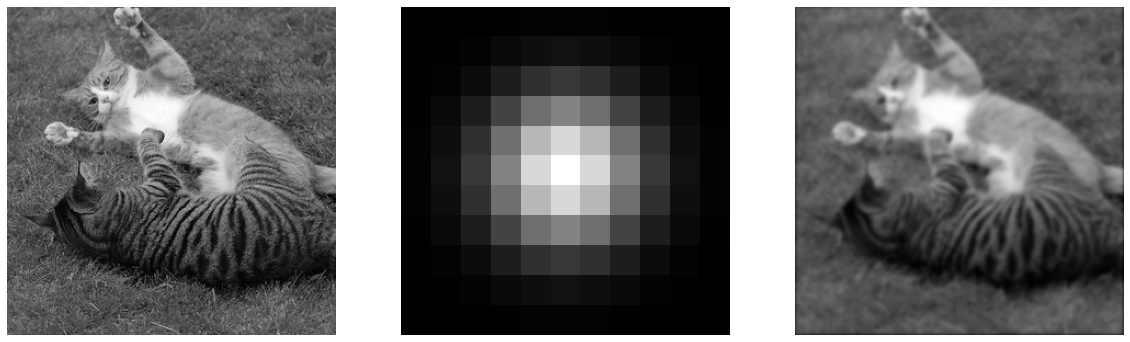

In [73]:
from PIL import Image
import numpy as np
from scipy.signal import fftconvolve

std = 3.0
f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y]))
X, Y = np.meshgrid(np.arange(-5, 6, 1, dtype=np.float32), np.arange(-5, 6, 1, dtype=np.float32))
kernel = f(X, Y)
kernel = kernel / kernel.sum()

img = np.asarray(Image.open('cat.jpg').convert('L').crop((20, 40, 320, 340)))
print(img.shape)
plt.figure(figsize=(20, 12))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(kernel, cmap='gray')
plt.axis('off')

decay = fftconvolve(img, kernel, mode='same')
plt.subplot(1, 3, 3)
plt.imshow(decay, cmap='gray')
plt.axis('off')
plt.show()